In [1]:
# --- Cell 1: Imports ---
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU,
                                     GlobalAveragePooling2D, Dense, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import tensorflow_model_optimization as tfmot
# REMOVED: from tensorflow_model_optimization.python.core.quantization.keras.quantize_scheme import QuantizeScheme
# This is no longer needed with tfmot 0.8.0's recommended QAT approach.


In [2]:
# --- Cell 2: Paths & Parameters ---
# --- Configuration ---
# --- Configuration ---
# Define base directory for your dataset and models
base_dir = r"D:\School\Project\Machine_Learning\Datasets"
train_dir = os.path.join(base_dir, "Train") 
model_dir = os.path.join(base_dir, "Models" , "QAT_5Classes")

# Create the models directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Image dimensions and batch size
img_height, img_width = 120, 160
batch_size = 16

# Get class names from the training directory
# IMPORTANT: If you reduce classes, physically remove the class folders from train_dir
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
num_classes = len(class_names)
print(f"Classes: {class_names}\nTotal classes: {num_classes}")

# Set random seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"Random seeds set to {SEED} for reproducibility.")

Classes: ['Grass_Paths', 'Gravel_Stony', 'PaveTile', 'Stairs', 'Tarmac']
Total classes: 5
Random seeds set to 42 for reproducibility.


In [3]:
# --- Cell 3: Prepare Data with ImageDataGenerator's built-in split ---
# --- Prepare Data with ImageDataGenerator's built-in split ---
print("\nPreparing data generators using built-in validation split...")

train_gen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

val_gen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=SEED
)
val_data = val_gen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)
print(f"Data generators prepared. Train samples: {train_data.samples}, Validation samples: {val_data.samples}.")


Preparing data generators using built-in validation split...
Found 10522 images belonging to 5 classes.
Found 1853 images belonging to 5 classes.
Data generators prepared. Train samples: 10522, Validation samples: 1853.



Displaying sample images from each class...


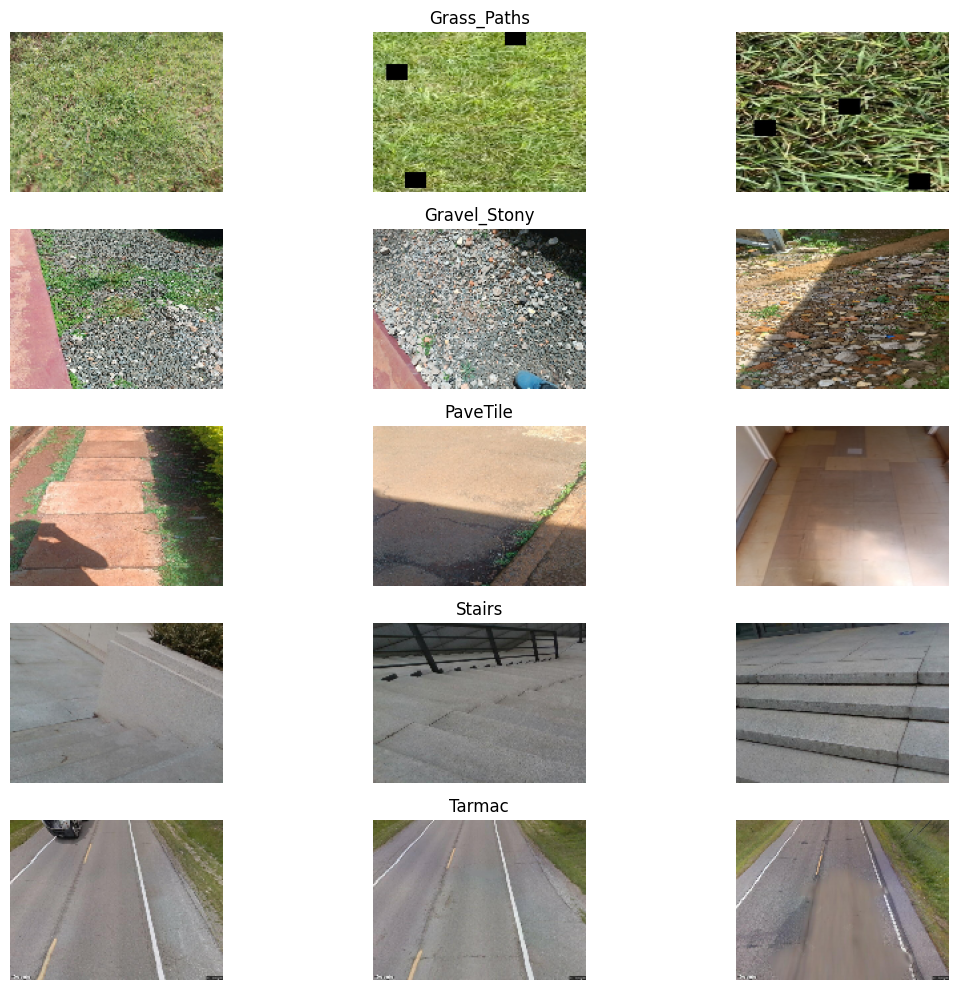

Sample images displayed.
Verified 10522 training images and 1853 validation images.


In [4]:
# --- Cell 4: Show Sample Images and Data Quality Check ---
print("\nDisplaying sample images from each class...")
fig, axes = plt.subplots(len(class_names), 3, figsize=(12, len(class_names)*2))

for i, cls_name in enumerate(class_names):
    cls_path = os.path.join(train_dir, cls_name) # Assuming train_dir contains class subfolders
    
    # Get all image files in the class directory
    # Filter for common image extensions if necessary
    all_class_images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    if not all_class_images:
        print(f"Warning: No valid image files found for class '{cls_name}' in '{cls_path}'.")
        for j in range(3):
            axes[i, j].axis('off')
            if j == 1:
                axes[i, j].set_title(f"{cls_name} (No images found)", color='red')
        continue

    # Randomly select up to 3 images from the class
    display_img_names = random.sample(all_class_images, min(3, len(all_class_images)))
    
    for j, img_name in enumerate(display_img_names):
        img_path = os.path.join(cls_path, img_name)
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Could not read image: {img_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV reads BGR, Matplotlib expects RGB
            img = cv2.resize(img, (img_width, img_height)) # Resize to model input size
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 1:
                axes[i, j].set_title(cls_name)
        except Exception as e:
            print(f"Error loading/displaying image {img_path}: {e}")
            axes[i, j].axis('off')
            if j == 1:
                axes[i, j].set_title(f"{cls_name} (Error)", color='red')
            
    # If fewer than 3 images were displayed, turn off remaining axes
    for j_fill in range(len(display_img_names), 3):
        axes[i, j_fill].axis('off')

plt.tight_layout()
plt.show()
print("Sample images displayed.")

try:
    if train_data.samples == 0:
        raise ValueError("No images found in training directory. Check paths and image files.")
    if val_data.samples == 0:
        raise ValueError("No images found in validation directory. Check paths and image files.")
    print(f"Verified {train_data.samples} training images and {val_data.samples} validation images.")
except ValueError as e:
    print(f"Data loading error: {e}")
    pass

In [5]:
# --- Cell 5: Class Weights ---
labels = train_data.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights for training: {class_weights_dict}")

Class weights for training: {0: 1.7864176570458403, 1: 3.2829953198127924, 2: 0.9012419700214133, 3: 0.6082080924855491, 4: 0.7236588720770288}


In [6]:
# --- Cell 6: Define Custom Neural Network Model with Manual QAT Annotations ---
# --- Define Custom Neural Network Model with Manual QAT Annotations (Higher Parameters) ---
# This function defines the neural network architecture with increased capacity
# to target a parameter count between 20K and 30K.
def create_custom_nn_model_with_qat(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Use `tfmot.quantization.keras.quantize_annotate_layer` to mark layers for QAT.
    quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer

    # Define custom scope for layers for `load_model` and `quantize_model` (if used).
    # This ensures that TensorFlow knows how to handle these layers when wrapped by TF-MOT.
    custom_q_scope_for_model_def = {
        'Conv2D': Conv2D,
        'DepthwiseConv2D': DepthwiseConv2D,
        'BatchNormalization': BatchNormalization,
        'ReLU': ReLU,
        # Include any other custom layers or activations if your model uses them
    }

    with tfmot.quantization.keras.quantize_scope(custom_q_scope_for_model_def):
        # Increased filters significantly to reach ~30K-35K parameters
        # Block 1
        x = quantize_annotate_layer(Conv2D(24, (3, 3), strides=2, padding='same'))(inputs) # Was 16
        x = quantize_annotate_layer(BatchNormalization())(x)
        x = quantize_annotate_layer(ReLU())(x)

        # Block 2
        x = quantize_annotate_layer(DepthwiseConv2D((3, 3), padding='same'))(x)
        x = quantize_annotate_layer(BatchNormalization())(x)
        x = quantize_annotate_layer(ReLU())(x)
        x = quantize_annotate_layer(Conv2D(48, (1, 1), padding='same'))(x) # Was 32
        x = quantize_annotate_layer(BatchNormalization())(x)
        x = quantize_annotate_layer(ReLU())(x)

        # Block 3
        x = quantize_annotate_layer(DepthwiseConv2D((3, 3), strides=2, padding='same'))(x)
        x = quantize_annotate_layer(BatchNormalization())(x)
        x = quantize_annotate_layer(ReLU())(x)
        x = quantize_annotate_layer(Conv2D(64, (1, 1), padding='same'))(x) # Was 48
        x = quantize_annotate_layer(BatchNormalization())(x)
        x = quantize_annotate_layer(ReLU())(x)

        # Block 4
        x = quantize_annotate_layer(DepthwiseConv2D((3, 3), padding='same'))(x)
        x = quantize_annotate_layer(BatchNormalization())(x)
        x = quantize_annotate_layer(ReLU())(x)
        x = quantize_annotate_layer(Conv2D(64, (1, 1), padding='same'))(x) # Was 48
        x = quantize_annotate_layer(BatchNormalization())(x)
        x = quantize_annotate_layer(ReLU())(x)

        # Block 5
        x = quantize_annotate_layer(DepthwiseConv2D((3, 3), strides=2, padding='same'))(x)
        x = quantize_annotate_layer(BatchNormalization())(x)
        x = quantize_annotate_layer(ReLU())(x)
        x = quantize_annotate_layer(Conv2D(128, (1, 1), padding='same'))(x) # Was 96
        x = quantize_annotate_layer(BatchNormalization())(x)
        x = quantize_annotate_layer(ReLU())(x)

        x = GlobalAveragePooling2D()(x)
        # Increased Dense layer from 96 to 128
        x = Dense(128, activation='relu')(x) 
        x = Dropout(0.25)(x)
        outputs = Dense(num_classes, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model

# Create the QAT-enabled model using the manually annotated definition
print("\nCreating QAT-enabled model with explicit layer annotations (Higher Parameters)...")
model = create_custom_nn_model_with_qat((img_height, img_width, 3), num_classes)

# Compile the model.
initial_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nModel Summary (New Model with Higher Parameters):")
model.summary()
print("✅ QAT-enabled model successfully created and compiled.")


Creating QAT-enabled model with explicit layer annotations (Higher Parameters)...



Model Summary (New Model with Higher Parameters):
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 160, 3)]     0         
                                                                 
 quantize_annotate (Quantiz  (None, 60, 80, 24)        672       
 eAnnotate)                                                      
                                                                 
 quantize_annotate_1 (Quant  (None, 60, 80, 24)        96        
 izeAnnotate)                                                    
                                                                 
 quantize_annotate_2 (Quant  (None, 60, 80, 24)        0         
 izeAnnotate)                                                    
                                                         

In [7]:
# --- Cell 7: Callbacks ---
callbacks = [
    # Early stopping: stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6), # Lower min_lr
    # Save the best model based on validation accuracy. This will be the QAT-enabled Keras model.
    ModelCheckpoint(os.path.join(model_dir, "QAT_best.h5"), save_best_only=True, monitor="val_accuracy")
]

In [8]:
# --- Cell 8: Train Quantization-Aware Model ---
# --- Train Quantization-Aware Model from Scratch ---
print("\nStarting Quantization-Aware Training (QAT) from scratch (New Model)...")
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50, # Increased epochs, rely on EarlyStopping for actual stopping point
    class_weight=class_weights_dict, # Use the computed class weights
    callbacks=callbacks
)
print("✅ Quantization-Aware Training completed.")


Starting Quantization-Aware Training (QAT) from scratch (New Model)...
Epoch 1/50


658/658 [==============================] - ETA: 0s - loss: 0.9317 - accuracy: 0.5884

C:\Users\manas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


658/658 [==============================] - 811s 1s/step - loss: 0.9317 - accuracy: 0.5884 - val_loss: 0.7637 - val_accuracy: 0.6972 - lr: 1.0000e-04
Epoch 2/50
658/658 [==============================] - 451s 686ms/step - loss: 0.6073 - accuracy: 0.7263 - val_loss: 0.8650 - val_accuracy: 0.7107 - lr: 1.0000e-04
Epoch 3/50
658/658 [==============================] - 487s 741ms/step - loss: 0.5551 - accuracy: 0.7481 - val_loss: 0.6650 - val_accuracy: 0.7852 - lr: 1.0000e-04
Epoch 4/50
658/658 [==============================] - 576s 876ms/step - loss: 0.5061 - accuracy: 0.7699 - val_loss: 0.6208 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 5/50
658/658 [==============================] - 428s 651ms/step - loss: 0.4830 - accuracy: 0.7812 - val_loss: 0.6750 - val_accuracy: 0.7674 - lr: 1.0000e-04
Epoch 6/50
658/658 [==============================] - 354s 538ms/step - loss: 0.4485 - accuracy: 0.8002 - val_loss: 0.5430 - val_accuracy: 0.8365 - lr: 1.0000e-04
Epoch 7/50
658/658 [================

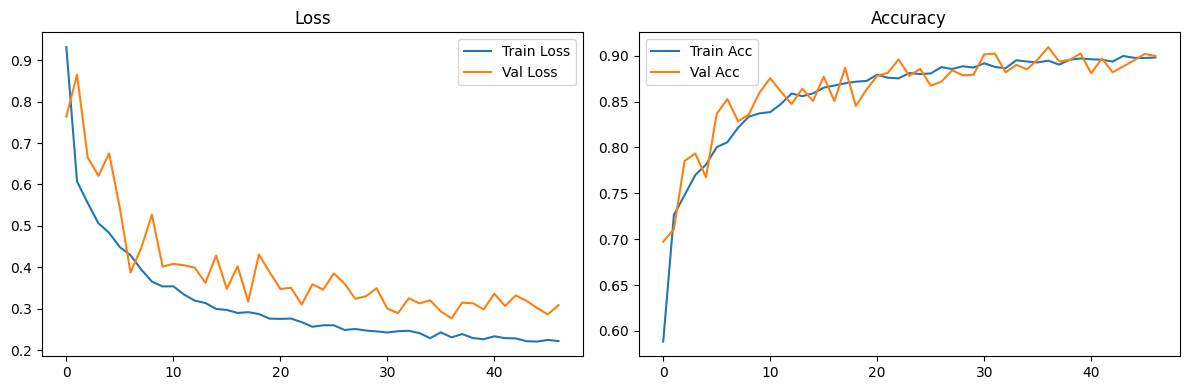

In [9]:
# --- Cell 9: Plot Metrics ---
# --- Plot Metrics ---
# Plot training and validation loss and accuracy over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# --- Cell 10: Save Final QAT Keras Model ---
# Save the final trained QAT model in Keras native format.
# This model still contains the fake quantization operations.
model.save(os.path.join(model_dir, "5_classes.keras"))
print(f"Final QAT Keras model saved to {model_dir}")

Final QAT Keras model saved to D:\School\Project\Machine_Learning\Datasets\Models\QAT_5Classes


In [11]:
# --- Cell 11: Convert QAT Model to TFLite (INT8) ---
print("\nConverting QAT Keras model to INT8 TFLite...")

# Use the trained QAT model directly for conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply default optimizations, which primarily enable full integer quantization
# when a representative dataset and target_spec are provided.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# IMPORTANT: Provide a representative dataset for full integer quantization (INT8).
# This is crucial for TFLite Micro to determine optimal min/max ranges for activations.
def representative_data_gen():
    num_samples_to_collect = 100 # Aim for 100 diverse samples
    collected_images = []

    # Reset data generator to ensure we sample from the beginning of the dataset
    train_data.reset()
    for batch_images, _ in train_data:
        for img in batch_images:
            if len(collected_images) < num_samples_to_collect:
                # Expand dimensions to create a batch of 1, as expected by the converter
                collected_images.append(tf.expand_dims(img, axis=0))
            else:
                break # Stop collecting once enough samples are gathered
        if len(collected_images) >= num_samples_to_collect:
            break # Stop iterating through batches

    # Yield each collected image (as a batch of 1 tensor)
    for img_tensor in collected_images:
        yield [img_tensor]

# Set the representative dataset for the converter
converter.representative_dataset = representative_data_gen

# Suggested Fix: Explicitly specify INT8 as the target operations set for edge deployment.
# This will ensure the model only uses integer operations. If any layer cannot be
# quantized to INT8, the conversion will fail, indicating a compatibility issue.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Suggested Fix: Explicitly set inference input and output types to INT8.
# This is vital for TFLite Micro, ensuring the entire model operates on INT8 values.
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Perform the conversion to INT8 TFLite model
quant_tflite = converter.convert()

# Save the quantized TFLite model
with open(os.path.join(model_dir, "5_classes_int8.tflite"), "wb") as f:
    f.write(quant_tflite)

print("Quantized TFLite model (INT8) saved successfully.")
print(f"Quantized TFLite model saved to {os.path.join(model_dir, 'custom_nn_model_quant_int8.tflite')}")



Converting QAT Keras model to INT8 TFLite...
INFO:tensorflow:Assets written to: C:\Users\manas\AppData\Local\Temp\tmpb8rx3vfk\assets


INFO:tensorflow:Assets written to: C:\Users\manas\AppData\Local\Temp\tmpb8rx3vfk\assets
C:\Users\manas\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized TFLite model (INT8) saved successfully.
Quantized TFLite model saved to D:\School\Project\Machine_Learning\Datasets\Models\QAT_5Classes\custom_nn_model_quant_int8.tflite


In [14]:
# --- Cell 12: Evaluate Models ---
# Suggested Fix: Add a function to evaluate both Keras (float/QAT) and TFLite (INT8) models.

def evaluate_tflite_model(tflite_model_path, data_generator):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_dtype = input_details[0]['dtype']

    predictions = []
    true_labels = []

    print(f"Evaluating {os.path.basename(tflite_model_path)}...")

    # Reset data generator to ensure consistent evaluation from the start
    data_generator.reset()
    # The number of batches to evaluate needs to be capped, especially if the generator
    # is infinite or evaluation is only on validation set.
    # We evaluate on the entire validation set.
    total_batches = len(data_generator)

    for i, (images, labels) in enumerate(data_generator):
        if i >= total_batches:
            break

        for j in range(images.shape[0]): # Iterate through individual images in the batch
            input_data = images[j:j+1] # Get a single image with batch dimension (e.g., (1, H, W, C))

            # If input expects INT8, quantize the float input
            if input_dtype == np.int8:
                input_scale, input_zero_point = input_details[0]['quantization']
                input_data = (input_data / input_scale + input_zero_point).astype(np.int8)
            # Ensure input data is of the correct type
            input_data = input_data.astype(input_dtype)

            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # If output is INT8, de-quantize it to float for comparison
            if output_details[0]['dtype'] == np.int8:
                output_scale, output_zero_point = output_details[0]['quantization']
                output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale

            predictions.append(np.argmax(output_data))
            true_labels.append(np.argmax(labels[j])) # Get true label for this single image

    accuracy = np.sum(np.array(predictions) == np.array(true_labels)) / len(predictions)
    print(f"Accuracy on validation set for {os.path.basename(tflite_model_path)}: {accuracy:.4f}")
    return accuracy

# Load the best Keras QAT model saved by ModelCheckpoint for evaluation
try:
    # Need to load with quantize_scope because the saved model contains the QAT ops
    with tfmot.quantization.keras.quantize_scope({
        'DepthwiseConv2D': DepthwiseConv2D, 'ReLU': ReLU, 'Conv2D': Conv2D
    }):
        best_keras_model = tf.keras.models.load_model(os.path.join(model_dir, "QAT_best.h5"))
    print("Loaded best Keras QAT model for evaluation.")
except Exception as e:
    print(f"Could not load best_keras_model. Using final trained 'model' for evaluation. Error: {e}")
    best_keras_model = model # Fallback to the final trained model if loading fails

# Evaluate the QAT Keras model (before TFLite conversion, with fake ops)
print("\n--- Evaluation of Keras Models ---")
loss, acc = best_keras_model.evaluate(val_data, verbose=0)
print(f"Accuracy of Keras QAT model (with fake ops) on validation set: {acc:.4f}")


# Evaluate the INT8 TFLite model
print("\n--- Evaluation of TFLite Models ---")

# First, convert the best_keras_model to float TFLite for comparison (optional but good for debugging)
float_converter = tf.lite.TFLiteConverter.from_keras_model(best_keras_model)
float_tflite_model = float_converter.convert()
float_tflite_path = os.path.join(model_dir, "custom_nn_model_float.tflite")
with open(float_tflite_path, "wb") as f:
    f.write(float_tflite_model)
print(f"Float TFLite model saved for comparison at {float_tflite_path}")

# Evaluate the float TFLite model
evaluate_tflite_model(float_tflite_path, val_data)

# Evaluate the INT8 TFLite model
evaluate_tflite_model(os.path.join(model_dir, "5_classes_int8.tflite"), val_data)

print("Model evaluation complete.")

Loaded best Keras QAT model for evaluation.

--- Evaluation of Keras Models ---
Accuracy of Keras QAT model (with fake ops) on validation set: 0.9093

--- Evaluation of TFLite Models ---
INFO:tensorflow:Assets written to: C:\Users\manas\AppData\Local\Temp\tmp0m7la50u\assets


INFO:tensorflow:Assets written to: C:\Users\manas\AppData\Local\Temp\tmp0m7la50u\assets


Float TFLite model saved for comparison at D:\School\Project\Machine_Learning\Datasets\Models\QAT_5Classes\custom_nn_model_float.tflite
Evaluating custom_nn_model_float.tflite...
Accuracy on validation set for custom_nn_model_float.tflite: 0.9093
Evaluating 5_classes_int8.tflite...
Accuracy on validation set for 5_classes_int8.tflite: 0.9147
Model evaluation complete.
